<h1><b>FINAL PROJECT BIG DATA PREDICTIVE ANALYTICS LANJUT</b></h1>
  <p><b>ANGGOTA KELOMPOK : </b><p>
<ul>
  <li>Haikal Raditya Fadhilah (21.11.3910)</li>
  <li>Sulthan Asyarf Donison (21.11.3902)</li>
  <li>Syifa Zahra Sasongko (21.11.3894)</li>
  <li>Alexandra Gloria Doke (21.11.3956)</li>
<ul>

<h2><b>INSTALL PYSPARK</b></h2>

In [8]:
# !pip install pyspark

<h2><b>IMPORT LIBRARY</b></h2>

In [47]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,isnan,when,count,expr, udf
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier,MultilayerPerceptronClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

<h2><b>CREATE SESSION SPARK</b></h2>

In [10]:
spark = SparkSession.builder.getOrCreate()

<h2><b>IMPORT DATASET</b></h2>

In [11]:
# path = './Covid Data.csv'
path = '/content/drive/MyDrive/Big Data & Predictive Analytics Lanjut/FP/Covid Data.csv'
df = spark.read.csv(path,inferSchema=True,header=True)

<h2><b>PREPARE DATASET</b></h2>

<h3><b>MELIHAT CONTOH DATASET</b></h3>

In [12]:
df.show(5)

+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|USMER|MEDICAL_UNIT|SEX|PATIENT_TYPE| DATE_DIED|INTUBED|PNEUMONIA|AGE|PREGNANT|DIABETES|COPD|ASTHMA|INMSUPR|HIPERTENSION|OTHER_DISEASE|CARDIOVASCULAR|OBESITY|RENAL_CHRONIC|TOBACCO|CLASIFFICATION_FINAL|ICU|
+-----+------------+---+------------+----------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|    2|           1|  1|           1|03/05/2020|     97|        1| 65|       2|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   3| 97|
|    2|           1|  2|           1|03/06/2020|     97|        1| 72|      97|       2|   2|     2|      2|           1|            2|             2|      1|            1|    

<h3><b>MENGHAPUS COLUMN YANG KURANG BERGUNA</b></h3>

In [13]:
df = df.drop('DATE_DIED')

<h3><b>MELIHAT JUMLAH KOLOM DAN BARIS DATASET</b></h3>

In [14]:
print(f"Jumlah Baris Dalam Dataset : {df.count()} Baris")
print(f"Jumlah Kolom Dalam Dataset : {len(df.columns)}")

Jumlah Baris Dalam Dataset : 1048575 Baris
Jumlah Kolom Dalam Dataset : 20


<h3><b>MELIHAT TIPE DATA DARI SETIAP KOLOM</b></h3>

In [15]:
df.printSchema()

root
 |-- USMER: integer (nullable = true)
 |-- MEDICAL_UNIT: integer (nullable = true)
 |-- SEX: integer (nullable = true)
 |-- PATIENT_TYPE: integer (nullable = true)
 |-- INTUBED: integer (nullable = true)
 |-- PNEUMONIA: integer (nullable = true)
 |-- AGE: integer (nullable = true)
 |-- PREGNANT: integer (nullable = true)
 |-- DIABETES: integer (nullable = true)
 |-- COPD: integer (nullable = true)
 |-- ASTHMA: integer (nullable = true)
 |-- INMSUPR: integer (nullable = true)
 |-- HIPERTENSION: integer (nullable = true)
 |-- OTHER_DISEASE: integer (nullable = true)
 |-- CARDIOVASCULAR: integer (nullable = true)
 |-- OBESITY: integer (nullable = true)
 |-- RENAL_CHRONIC: integer (nullable = true)
 |-- TOBACCO: integer (nullable = true)
 |-- CLASIFFICATION_FINAL: integer (nullable = true)
 |-- ICU: integer (nullable = true)



<h3><b>MELIHAT DATA NULL DARI SETIAP KOLOM</b></h3>

In [16]:
df.select([count(when((col(c).isNull() | isnan(col(c)) | (col(c) == 'NA')), c)).alias(c) for c in df.columns]).toPandas().T

,0
USMER,0
MEDICAL_UNIT,0
SEX,0
PATIENT_TYPE,0
INTUBED,0
PNEUMONIA,0
AGE,0
PREGNANT,0
DIABETES,0
COPD,0


<h3><b>MENGHAPUS DATA NULL ATAU 'NA'</b></h3>

In [17]:
df = df.na.drop()

<h3><b>MENGGANTI NAMA KOLOM MENJADI HURUF KECIL</b></h3>

In [18]:
df = df.select(*[col(c).alias(c.lower()) for c in df.columns])

<h3><b>MENGUBAH NILAI "PATIENT_TYPE" MENJADI BINARY 0 DAN 1</b></h3>

In [19]:
df = df.withColumn("patient_type", when(df["patient_type"] == 1.0, 0).otherwise(1))

<h2><b>DATA PRE-PROCESSING</b></h2>

<h3><b>MELIHAT DATA 5 TERATAS</b></h3>

In [20]:
df.show(5)

+-----+------------+---+------------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|usmer|medical_unit|sex|patient_type|intubed|pneumonia|age|pregnant|diabetes|copd|asthma|inmsupr|hipertension|other_disease|cardiovascular|obesity|renal_chronic|tobacco|clasiffication_final|icu|
+-----+------------+---+------------+-------+---------+---+--------+--------+----+------+-------+------------+-------------+--------------+-------+-------------+-------+--------------------+---+
|    2|           1|  1|           0|     97|        1| 65|       2|       2|   2|     2|      2|           1|            2|             2|      2|            2|      2|                   3| 97|
|    2|           1|  2|           0|     97|        1| 72|      97|       2|   2|     2|      2|           1|            2|             2|      1|            1|      2|                   5| 97|
|    2|           1|  2| 

<h3><b>MELIHAT DESKRIPSI DATASET</b></h3>

In [21]:
df.describe().toPandas()

,summary,usmer,medical_unit,sex,patient_type,intubed,pneumonia,age,pregnant,diabetes,...,asthma,inmsupr,hipertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,clasiffication_final,icu
0,count,1048575,1048575,1048575,1048575,1048575,1048575,1048575,1048575,1048575,...,1048575,1048575,1048575,1048575,1048575,1048575,1048575,1048575,1048575,1048575
1,mean,1.6321941682759935,8.980565052571347,1.4992594711870872,0.19076460911236678,79.52287533080609,3.3468306988055216,41.794102472403026,49.76558472212288,2.1864044059795438,...,2.2426264215721337,2.2981322270700715,2.1289893426793505,2.435142932074482,2.2618095987411486,2.125175595450969,2.2571795055193955,2.2143327849700785,5.305652909901533,79.55397372624752
2,stddev,0.4822083819543978,3.7232777781998068,0.4999996900354941,0.3929040852992912,36.86888627504458,11.912881086508081,16.907389199431215,47.51073271107632,5.424241787888338,...,5.114089259421973,5.462843261101432,5.236397094606129,6.646675591074688,5.194850371652726,5.175445110188367,5.1353538533995104,5.323097220663583,1.8811654309355843,36.82307335289849
3,min,1,1,1,0,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
4,max,2,13,2,1,99,99,121,98,98,...,98,98,98,98,98,98,98,98,7,99


<h3><b>MELIHAT JUMLAH DATA UNIQUE TIAP KOLOM</b></h3>

In [22]:
for x in df.columns:
    print(f"Kolom '{x}' Memiliki Jumlah Data Unique Sebanyak : {df.dropDuplicates([x]).select(x).count()}")

Kolom 'usmer' Memiliki Jumlah Data Unique Sebanyak : 2
Kolom 'medical_unit' Memiliki Jumlah Data Unique Sebanyak : 13
Kolom 'sex' Memiliki Jumlah Data Unique Sebanyak : 2
Kolom 'patient_type' Memiliki Jumlah Data Unique Sebanyak : 2
Kolom 'intubed' Memiliki Jumlah Data Unique Sebanyak : 4
Kolom 'pneumonia' Memiliki Jumlah Data Unique Sebanyak : 3
Kolom 'age' Memiliki Jumlah Data Unique Sebanyak : 121
Kolom 'pregnant' Memiliki Jumlah Data Unique Sebanyak : 4
Kolom 'diabetes' Memiliki Jumlah Data Unique Sebanyak : 3
Kolom 'copd' Memiliki Jumlah Data Unique Sebanyak : 3
Kolom 'asthma' Memiliki Jumlah Data Unique Sebanyak : 3
Kolom 'inmsupr' Memiliki Jumlah Data Unique Sebanyak : 3
Kolom 'hipertension' Memiliki Jumlah Data Unique Sebanyak : 3
Kolom 'other_disease' Memiliki Jumlah Data Unique Sebanyak : 3
Kolom 'cardiovascular' Memiliki Jumlah Data Unique Sebanyak : 3
Kolom 'obesity' Memiliki Jumlah Data Unique Sebanyak : 3
Kolom 'renal_chronic' Memiliki Jumlah Data Unique Sebanyak : 3
Kolo

<h2><b>VISUALISASI DATA</b></h2>

<h3><b>MELIHAT VISUALISASI DATA CORELASI ANTAR VARIABEL</b></h3>

In [23]:
features = [col_name for col_name, col_type in df.dtypes if col_type in ['int', 'double','float']]
features

['usmer',
 'medical_unit',
 'sex',
 'patient_type',
 'intubed',
 'pneumonia',
 'age',
 'pregnant',
 'diabetes',
 'copd',
 'asthma',
 'inmsupr',
 'hipertension',
 'other_disease',
 'cardiovascular',
 'obesity',
 'renal_chronic',
 'tobacco',
 'clasiffication_final',
 'icu']

In [24]:
vector_assembler = VectorAssembler(inputCols=features, outputCol="features")
df_assembler = vector_assembler.transform(df).select("features")

In [25]:
matrix = Correlation.corr(df_assembler,"features").head()

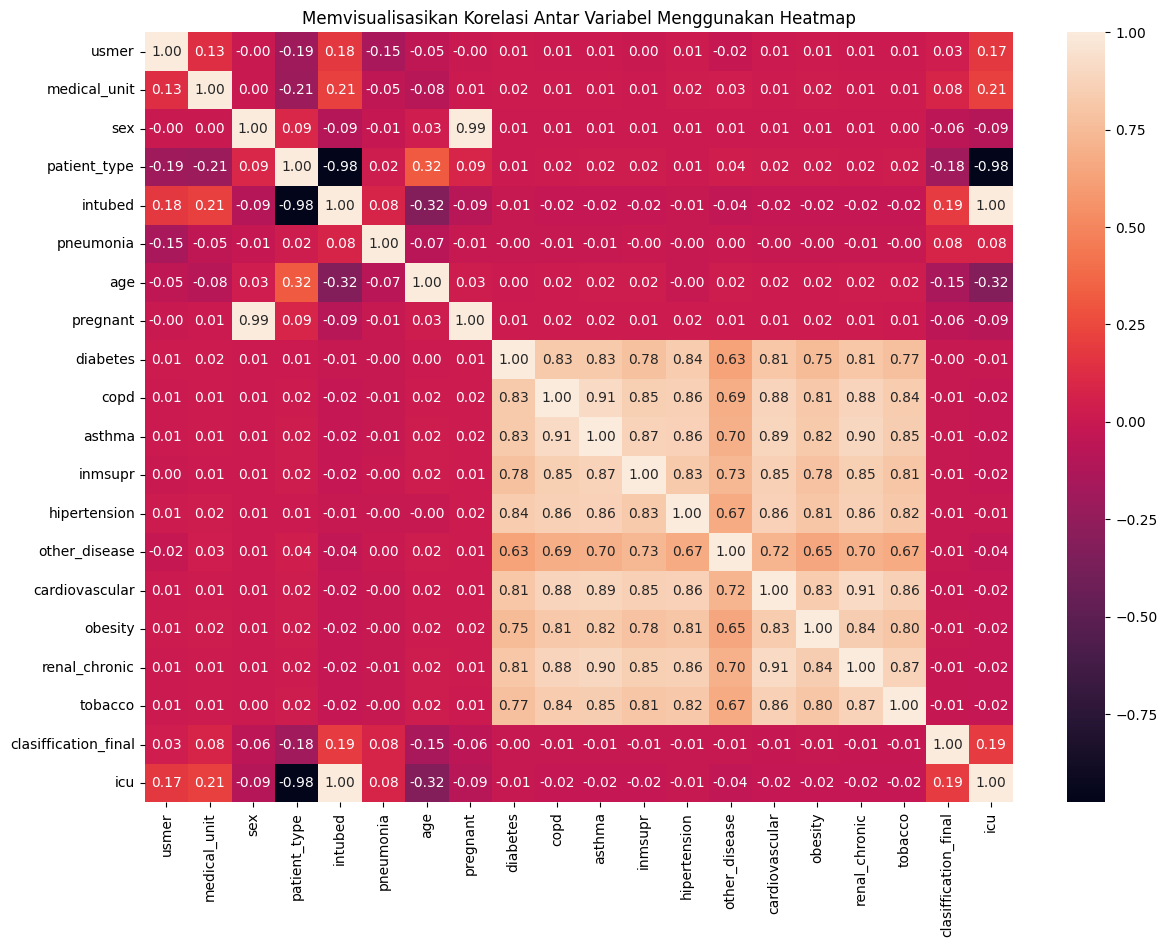

In [26]:
plt.figure(figsize=(14,10))
sns.heatmap(pd.DataFrame(matrix[0].toArray(),columns=features,index=features),fmt='.2f',annot=True, xticklabels=features, yticklabels=features)
plt.title("Memvisualisasikan Korelasi Antar Variabel Menggunakan Heatmap")
plt.show()

<h3><b>SELEKSI FITUR PREDIKSI</b></h3>

In [27]:
fitur_prediksi = ['age','medical_unit','usmer','clasiffication_final']
assembler = VectorAssembler(inputCols=fitur_prediksi,outputCol='independentFeature')
df_prediction = assembler.transform(df).select('independentFeature','patient_type')

<h3><b>MENAMPILKAN HASIL VECTOR INDEPENDENT FEATURE</b></h3>

In [28]:
df_prediction.show(5)

+------------------+------------+
|independentFeature|patient_type|
+------------------+------------+
|[65.0,1.0,2.0,3.0]|           0|
|[72.0,1.0,2.0,5.0]|           0|
|[55.0,1.0,2.0,3.0]|           1|
|[53.0,1.0,2.0,7.0]|           0|
|[68.0,1.0,2.0,3.0]|           0|
+------------------+------------+
only showing top 5 rows



<h2><b>BUILDING MODEL PREDICTION</b></h2>

<h3><b>LINEAR REGRESSION</b></h3>

<h4><b>SPLIT DATASET</b></h4>

In [29]:
train_data,test_data = df_prediction.randomSplit([0.7,0.3])

<h4><b>BUILD MODEL PREDICTION</b></h4>

In [30]:
linreg = LinearRegression(featuresCol='independentFeature',labelCol='patient_type')
linreg = linreg.fit(train_data)

<h4><b>PREDICTION DATA</b></h4>

In [31]:
predictions = linreg.transform(test_data)

In [32]:
prediction_data = linreg.evaluate(test_data)

<h4><b>SHOW PREDICTION DATA</b></h4>

In [33]:
prediction_data.predictions.show(5)

+------------------+------------+-------------------+
|independentFeature|patient_type|         prediction|
+------------------+------------+-------------------+
| [0.0,2.0,1.0,6.0]|           0|0.09718765245122907|
| [0.0,2.0,1.0,7.0]|           1|0.07109185516559324|
| [0.0,2.0,1.0,7.0]|           1|0.07109185516559324|
| [0.0,2.0,1.0,7.0]|           1|0.07109185516559324|
| [0.0,3.0,1.0,3.0]|           0|0.15932894405143427|
+------------------+------------+-------------------+
only showing top 5 rows



<h4><b>EVALUASI MODEL DENGAN RMSE</b></h4>

In [34]:
evaluator = RegressionEvaluator(labelCol="patient_type", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print(f"Nilai Root Mean Squared Error (RMSE): {rmse}")

Nilai Root Mean Squared Error (RMSE): 0.3575979986321467


<h4><b>EVALUASI MODEL DENGAN MSE</b></h4>

In [35]:
evaluator = RegressionEvaluator(labelCol="patient_type", predictionCol="prediction", metricName="mse")
mse = evaluator.evaluate(predictions)
print(f"Nili Mean Square Error (MSE): {mse}")

Nili Mean Square Error (MSE): 0.1278763286257168


<h3><b>LOGISTIC REGRESSION</b></h3>

<h4><b>SPLIT DATASET</b></h4>

In [36]:
train_data,test_data = df_prediction.randomSplit([0.7,0.3])

<h4><b>BUILD MODEL PREDICTION</b></h4>

In [37]:
logreg = LogisticRegression(featuresCol='independentFeature',labelCol='patient_type',maxIter=10, regParam=0.3, elasticNetParam=0.8, family="multinomial")

<h4><b>TRAINING MODEL</b></h4>

In [38]:
logreg_model = logreg.fit(train_data)

<h4><b>PREDICTION DATA FROM MODEL</b></h4>

In [39]:
logreg_prediction = logreg_model.transform(test_data)

<h4><b>HASIL PREDIKSI</b></h4>

In [40]:
logreg_prediction.show(5)

+------------------+------------+--------------------+--------------------+----------+
|independentFeature|patient_type|       rawPrediction|         probability|prediction|
+------------------+------------+--------------------+--------------------+----------+
| [0.0,2.0,1.0,5.0]|           1|[0.72058206572140...|[0.80863485913095...|       0.0|
| [0.0,3.0,1.0,3.0]|           0|[0.72058206572140...|[0.80863485913095...|       0.0|
| [0.0,3.0,1.0,3.0]|           0|[0.72058206572140...|[0.80863485913095...|       0.0|
| [0.0,3.0,1.0,3.0]|           0|[0.72058206572140...|[0.80863485913095...|       0.0|
| [0.0,3.0,1.0,3.0]|           1|[0.72058206572140...|[0.80863485913095...|       0.0|
+------------------+------------+--------------------+--------------------+----------+
only showing top 5 rows



<h4><b>MEMBUAT FUNGSI UNTUK DEFINISI MODEL</b></h4>

In [41]:
def evaluator_logistic(metricName):
    return MulticlassClassificationEvaluator(
    labelCol='patient_type',
    predictionCol='prediction',
    metricName=metricName
    )

<h4><b>EVALUASI MODEL PREDIKSI ACCURACY</b></h4>

In [42]:
evaluator = evaluator_logistic('accuracy')
accuracy = evaluator.evaluate(logreg_prediction)
print(f'Test Accuracy: {accuracy:.2%}')

Test Accuracy: 81.06%


<h4><b>EVALUASI MODEL PREDIKSI F1</b></h4>

In [43]:
evaluator = evaluator_logistic('f1')
f1 = evaluator.evaluate(logreg_prediction)
print(f"Nilai Evaluasi F1-Score : {f1:.2%} %" )

Nilai Evaluasi F1-Score : 72.59% %


<h4><b>EVALUASI MODEL PREDIKSI PRESISI</b></h4>

In [44]:
evaluator = evaluator_logistic('weightedPrecision')
f1 = evaluator.evaluate(logreg_prediction)
print(f"Nilai Evaluasi Presisi Model : {f1:.2%} %" )

Nilai Evaluasi Presisi Model : 65.71% %


<h4><b>EVALUASI MODEL PREDIKSI RECALL</b></h4>

In [45]:
evaluator = evaluator_logistic('weightedRecall')
f1 = evaluator.evaluate(logreg_prediction)
print(f"Nilai Evaluasi Presisi Model : {f1:.2%} %" )

Nilai Evaluasi Presisi Model : 81.06% %


<h4><b>EVALUASI AUC ROC</b></h4>

In [59]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import numpy as np

# Assuming 'probability' is the column containing the predicted probabilities for class 1
# Convert the array of arrays to a VectorUDT
to_vector_udf = F.udf(lambda arr: Vectors.dense(arr), VectorUDT())
logreg_prediction = logreg_prediction.withColumn('probability_vector', to_vector_udf('probability'))

# Convert 'patient_type' to a list for true labels
y_true = np.array(logreg_prediction.select('patient_type').collect())

# Create a DataFrame with 'prediction' and 'label' columns
prediction_and_label = logreg_prediction.select('probability_vector', 'patient_type') \
    .withColumnRenamed('probability_vector', 'prediction') \
    .select(F.col('prediction').alias('prediction'), 'patient_type')

# Instantiate BinaryClassificationEvaluator
binary_evaluator = BinaryClassificationEvaluator(labelCol='patient_type', rawPredictionCol='prediction')

# Evaluate the AUC-ROC
roc_auc = binary_evaluator.evaluate(prediction_and_label, {binary_evaluator.metricName: "areaUnderROC"})

print(f'AUC-ROC: {roc_auc:.2%}')


AUC-ROC: 50.00%


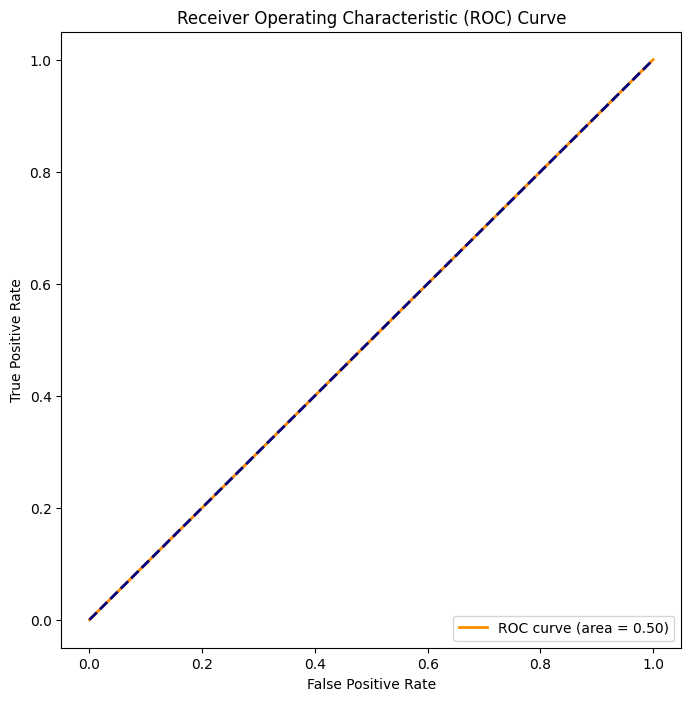

In [61]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Flatten the arrays in the 'probability' column
flatten_udf = F.udf(lambda arr: float(arr[1]), DoubleType())
logreg_prediction = logreg_prediction.withColumn('probability_flat', flatten_udf('probability'))

# Extract flattened probabilities and true labels
y_pred_prob = np.array(logreg_prediction.select('probability_flat').rdd.flatMap(lambda x: x).collect())
y_true = np.array(logreg_prediction.select('patient_type').rdd.flatMap(lambda x: x).collect())

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

<h3><b>RANDOM FOREST</b></h3>

<h4><b>SPLITING DATA</b></h4>

In [63]:
train_data,test_data = df_prediction.randomSplit([0.7,0.3])

<h4><b>BUILDING MODEL PREDICITON</b></h4>

In [64]:
randomForest = RandomForestClassifier(labelCol="patient_type",featuresCol='independentFeature',numTrees=100)

<h4><b>TRAINING MODEL PREDICTION</b></h4>

In [65]:
ranrest_model = randomForest.fit(train_data)

<h4><b>PREDICT DATA FROM MODEL</b></h4>

In [66]:
predictions = ranrest_model.transform(test_data)

<h4><b>EVALUASI MODEL ACCURACY</b></h4>

In [67]:
evaluator_ranrest = MulticlassClassificationEvaluator(labelCol='patient_type',predictionCol='prediction',metricName='accuracy')
accuracy_ranrest = evaluator_ranrest.evaluate(predictions)
print(f"Nilai Accuracy Model Random Forest : {accuracy_ranrest:.2%}")

Nilai Accuracy Model Random Forest : 84.58%


<h4><b>EVALUASI MODEL DENGAN F1-Score</b></h4>

In [68]:
evaluator_ranrest = MulticlassClassificationEvaluator(labelCol='patient_type',predictionCol='prediction',metricName='f1')
accuracy_ranrest = evaluator_ranrest.evaluate(predictions)
print(f"Nilai F1-Score Model Random Forest : {accuracy_ranrest:.2%}")

Nilai F1-Score Model Random Forest : 82.48%


<h4><b>EVALUASI MODEL DENGAN PRESISI</b></h4>

In [69]:
evaluator_ranrest = MulticlassClassificationEvaluator(labelCol='patient_type',predictionCol='prediction',metricName='weightedPrecision')
accuracy_ranrest = evaluator_ranrest.evaluate(predictions)
print(f"Nilai Presisi Model Random Forest : {accuracy_ranrest:.2%}")

Nilai Presisi Model Random Forest : 82.99%


<h4><b>EVALUASI MODEL DENGAN RECALL</b></h4>

In [70]:
evaluator_ranrest = MulticlassClassificationEvaluator(labelCol='patient_type',predictionCol='prediction',metricName='weightedRecall')
accuracy_ranrest = evaluator_ranrest.evaluate(predictions)
print(f"Nilai Presisi Model Random Forest : {accuracy_ranrest:.2%}")

Nilai Presisi Model Random Forest : 84.58%


<h4><b>EVALUASI AUC ROC</b></h4>

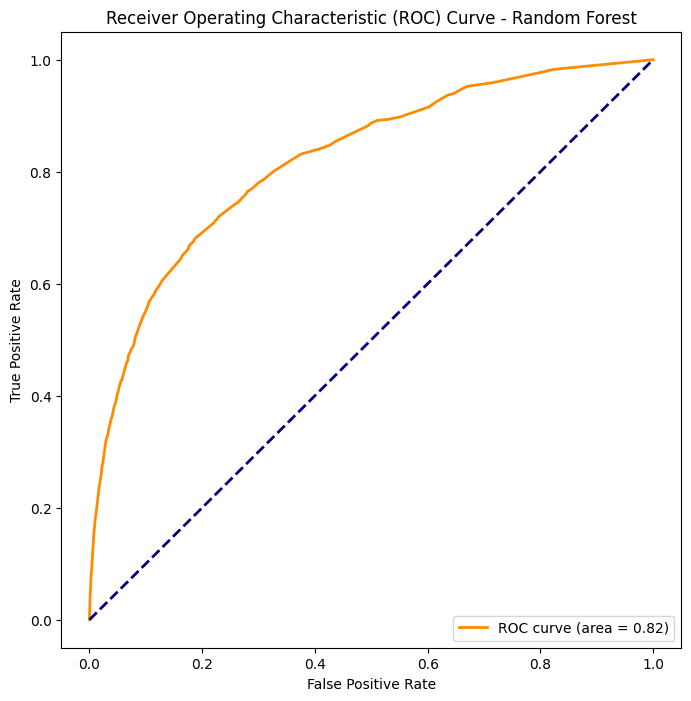

In [71]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'probability' is the column containing the predicted probabilities for class 1
y_pred_prob_rf = np.array(predictions.select('probability').rdd.flatMap(lambda x: x[0]).collect())
y_true_rf = np.array(predictions.select('patient_type').rdd.flatMap(lambda x: x).collect())

# Flatten the arrays in the 'probability' column
flatten_udf_rf = F.udf(lambda arr: float(arr[1]), DoubleType())
predictions_rf = predictions.withColumn('probability_flat', flatten_udf_rf('probability'))

# Extract flattened probabilities and true labels
y_pred_prob_rf = np.array(predictions_rf.select('probability_flat').rdd.flatMap(lambda x: x).collect())
y_true_rf = np.array(predictions_rf.select('patient_type').rdd.flatMap(lambda x: x).collect())

# Compute ROC curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_true_rf, y_pred_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()


<h3><b>MULTILAYER PERCEPTRON CLASSIFIER</b></h3>

<h4><b>SPLITTING DATA</b></h4>

In [72]:
train_data,test_data = df_prediction.randomSplit([0.7,0.3])

<h4><b>INITIAL BUILDING MODEL MLP</b></h4>

In [73]:
layer = [4,5,2]
mlp = MultilayerPerceptronClassifier(layers=layer, labelCol="patient_type", featuresCol="independentFeature", seed=42)

<h4><b>TRAINING MODEL</b></h4>

In [74]:
mlp_model = mlp.fit(train_data)

<h4><b>PREDICTION DATA FROM MODEL</b></h4>

In [75]:
predictions = mlp_model.transform(test_data)

<h4><b>EVALUASI MODEL PREDIKSI DENGAN ACCURACY</b></h4>

In [76]:
evaluator_mlp = MulticlassClassificationEvaluator(labelCol='patient_type',predictionCol='prediction',metricName='accuracy')
accuracy_mlp = evaluator_mlp.evaluate(predictions)
print(f"Nilai Accuracy Model Random Forest : {accuracy_mlp:.2%}")

Nilai Accuracy Model Random Forest : 84.50%


<h4><b>EVALUASI MODEL PREDIKSI DENGAN F1-Score</b></h4>

In [77]:
evaluator_mlp = MulticlassClassificationEvaluator(labelCol='patient_type',predictionCol='prediction',metricName='f1')
f1_mlp = evaluator_mlp.evaluate(predictions)
print(f"Nilai Accuracy Model Random Forest : {f1_mlp:.2%}")

Nilai Accuracy Model Random Forest : 82.50%


<h4><b>EVALUASI MODEL PREDIKSI DENGAN PRESISI</b></h4>

In [78]:
evaluator_mlp = MulticlassClassificationEvaluator(labelCol='patient_type',predictionCol='prediction',metricName='weightedPrecision')
presisi_mlp = evaluator_mlp.evaluate(predictions)
print(f"Nilai Accuracy Model Random Forest : {presisi_mlp:.2%}")

Nilai Accuracy Model Random Forest : 82.80%


<h4><b>EVALUASI MODEL PREDIKSI DENGAN RECALL</b></h4>

In [79]:
evaluator_mlp = MulticlassClassificationEvaluator(labelCol='patient_type',predictionCol='prediction',metricName='weightedRecall')
recall_mlp = evaluator_mlp.evaluate(predictions)
print(f"Nilai Accuracy Model Random Forest : {f1_mlp:.2%}")

Nilai Accuracy Model Random Forest : 82.50%


<h4><b>EVALUASI AUC ROC</b></h4>

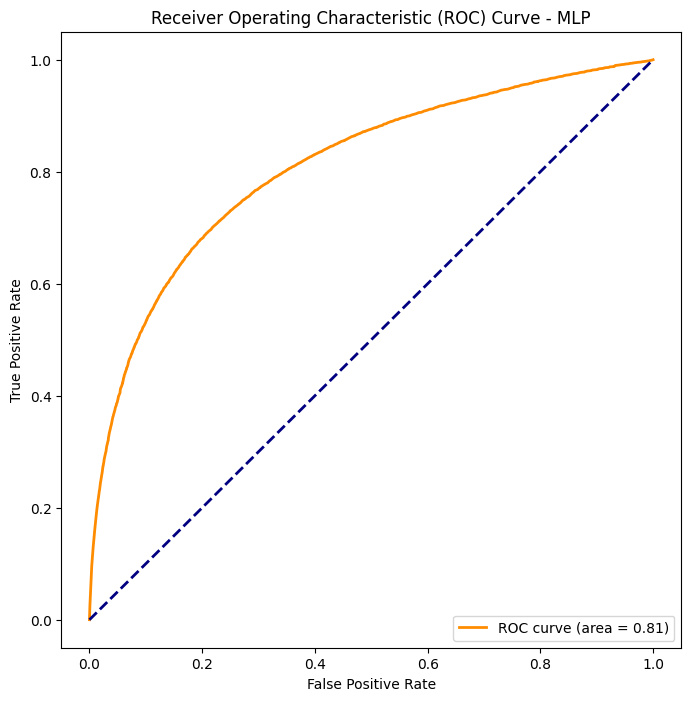

In [83]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'probability' is the column containing the predicted probabilities for class 1
y_pred_prob_mlp = np.array(predictions.select('probability').rdd.flatMap(lambda x: x[0]).collect())
y_true_mlp = np.array(predictions.select('patient_type').rdd.flatMap(lambda x: x).collect())

# Flatten the arrays in the 'probability' column
flatten_udf_mlp = F.udf(lambda arr: float(arr[1]), DoubleType())
predictions_mlp = predictions.withColumn('probability_flat', flatten_udf_mlp('probability'))

# Extract flattened probabilities and true labels
y_pred_prob_mlp = np.array(predictions_mlp.select('probability_flat').rdd.flatMap(lambda x: x).collect())
y_true_mlp = np.array(predictions_mlp.select('patient_type').rdd.flatMap(lambda x: x).collect())

# Compute ROC curve
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_true_mlp, y_pred_prob_mlp)
roc_auc_mlp = auc(fpr_mlp, tpr_mlp)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_mlp, tpr_mlp, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_mlp))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - MLP')
plt.legend(loc='lower right')
plt.show()


<h3><b>NAIVE BAYES</b></h3>

<h4><b>SPLITTING DATA</b></h4>

In [80]:
train_data,test_data = df_prediction.randomSplit([0.7,0.3])

<h4><b>BUILDING MODEL</b></h4>

In [81]:
nb = NaiveBayes(featuresCol='independentFeature', labelCol='patient_type', smoothing=1.0, modelType="multinomial")

<h4><b>TRAINING MODEL</b></h4>

In [85]:
nb_model = nb.fit(train_data)

<h4><b>PREDICTION MODEL</b></h4>

In [86]:
predictions = nb_model.transform(test_data)

<h4><b>EVALUASI MODEL DENGAN ACCURACY</b></h4>

In [87]:
evaluator_bayes = MulticlassClassificationEvaluator(
    labelCol='patient_type',
    predictionCol='prediction',
    metricName='accuracy'
)
accuracy_bayes = evaluator_bayes.evaluate(predictions)
print(f"Nilai Accuracy Model Dengan Naive Bayes : {accuracy_bayes:.2%}")

Nilai Accuracy Model Dengan Naive Bayes : 80.35%


<h4><b>EVALUASI MODEL DENGAN F1-Score</b></h4>

In [88]:
evaluator_bayes = MulticlassClassificationEvaluator(
    labelCol='patient_type',
    predictionCol='prediction',
    metricName='f1'
)
f1_bayes = evaluator_bayes.evaluate(predictions)
print(f"Nilai F1-Score Model Dengan Naive Bayes : {f1_bayes:.2%}")

Nilai F1-Score Model Dengan Naive Bayes : 80.80%


<h4><b>EVALUASI MODEL DENGAN PRESISI</b></h4>

In [89]:
evaluator_bayes = MulticlassClassificationEvaluator(
    labelCol='patient_type',
    predictionCol='prediction',
    metricName='weightedPrecision'
)
presisi_bayes = evaluator_bayes.evaluate(predictions)
print(f"Nilai Presisi Model Dengan Naive Bayes : {presisi_bayes:.2%}")

Nilai Presisi Model Dengan Naive Bayes : 81.36%


<h4><b>EVALUASI MODEL DENGAN RECALL</b></h4>

In [90]:
evaluator_bayes = MulticlassClassificationEvaluator(
    labelCol='patient_type',
    predictionCol='prediction',
    metricName='weightedRecall'
)
recall_bayes = evaluator_bayes.evaluate(predictions)
print(f"Nilai Recall Model Dengan Naive Bayes : {recall_bayes:.2%}")

Nilai Recall Model Dengan Naive Bayes : 80.35%


<h4><b>EVALUASI AUC ROC</b></h4>

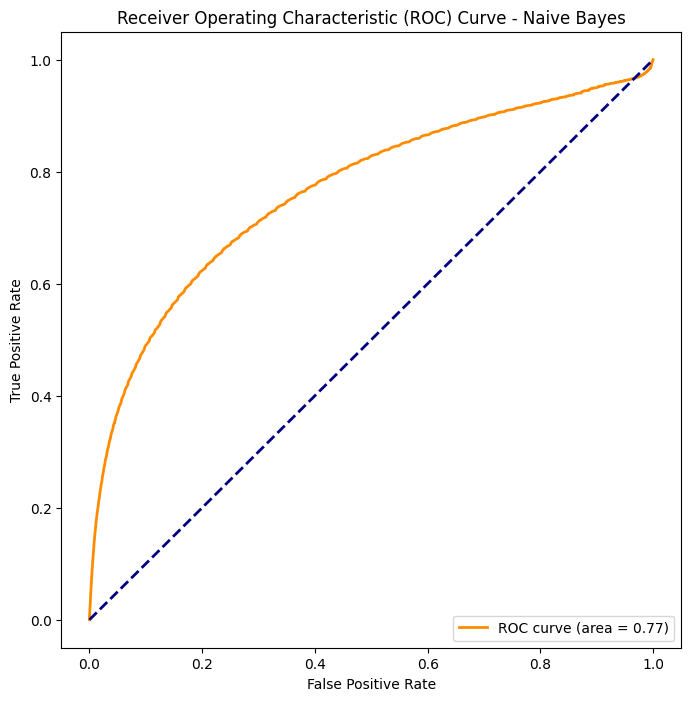

In [91]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming 'probability' is the column containing the predicted probabilities for class 1
y_pred_prob_bayes = np.array(predictions.select('probability').rdd.flatMap(lambda x: x[0]).collect())
y_true_bayes = np.array(predictions.select('patient_type').rdd.flatMap(lambda x: x).collect())

# Flatten the arrays in the 'probability' column
flatten_udf_bayes = F.udf(lambda arr: float(arr[1]), DoubleType())
predictions_bayes = predictions.withColumn('probability_flat', flatten_udf_bayes('probability'))

# Extract flattened probabilities and true labels
y_pred_prob_bayes = np.array(predictions_bayes.select('probability_flat').rdd.flatMap(lambda x: x).collect())
y_true_bayes = np.array(predictions_bayes.select('patient_type').rdd.flatMap(lambda x: x).collect())

# Compute ROC curve
fpr_bayes, tpr_bayes, thresholds_bayes = roc_curve(y_true_bayes, y_pred_prob_bayes)
roc_auc_bayes = auc(fpr_bayes, tpr_bayes)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_bayes, tpr_bayes, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_bayes))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Naive Bayes')
plt.legend(loc='lower right')
plt.show()


<h2><b>TUNING MODEL</b></h2>

<h3><b>TUNING MODEL RANDOM FOREST</b></h3>

<h4><b>SPLITTING DATASET</b></h4>

In [92]:
train_data,test_data = df_prediction.randomSplit([0.7,0.3])

<h4><b>CREATE MODEL RANDOM FOREST</b></h4>

In [93]:
rf = RandomForestClassifier(labelCol='patient_type', featuresCol='independentFeature')

<h4><b>CREATE PARAMATER GRID FOR HYPERPARAMATER TUNING</b></h4>

In [94]:
param_grid = (ParamGridBuilder()
    .addGrid(rf.numTrees, [10, 20, 30])
    .addGrid(rf.maxDepth, [5, 10, 15])
    .addGrid(rf.featureSubsetStrategy, ['auto', 'sqrt', 'log2'])
    .addGrid(rf.minInstancesPerNode, [1, 5, 10])
    .build())

<h4><b>CREATE EVALUATOR MODEL</b></h4>

In [95]:
evaluator = MulticlassClassificationEvaluator(labelCol='patient_type', predictionCol='prediction', metricName='accuracy')

<h4><b>CREATE CROSS-VALIDATOR MODEL PREDICTION</b></h4>

In [96]:
cv = CrossValidator(estimator=rf, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

<h4><b>TRAINING RANDOM FOREST TUNING</b></h4>

In [ ]:
tuning_ranrest_model = cv.fit(train_data)

<h4><b>PREDICTION DATA FROM MODEL</b></h4>

In [ ]:
predictions = tuning_ranrest_model.transform(test_data)

<h4><b>EVALUASI MODEL DENGAN ACCURACY</b></h4>

In [ ]:
evaluator_ranrest = MulticlassClassificationEvaluator(
    labelCol='patient_type',
    predictionCol='prediction',
    metricName='accuracy'
)
accuracy_ranrest = evaluator_ranrest.evaluate(predictions)
print(f"Nilai Accuracy Model Dengan Random Forest Tuning : {accuracy_ranrest:.2%}")

Nilai Accuracy Model Dengan Random Forest Tuning : 85.10%


<h4><b>EVALUASI MODEL DENGAN F1-Score</b></h4>

In [ ]:
evaluator_ranrest = MulticlassClassificationEvaluator(
    labelCol='patient_type',
    predictionCol='prediction',
    metricName='f1'
)
f1_ranrest = evaluator_ranrest.evaluate(predictions)
print(f"Nilai F1-Score Model Dengan Random Forest Tuning : {f1_ranrest:.2%}")

Nilai F1-Score Model Dengan Random Forest Tuning : 83.34%


<h4><b>EVALUASI MODEL DENGAN PRESISI</b></h4>

In [ ]:
evaluator_ranrest = MulticlassClassificationEvaluator(
    labelCol='patient_type',
    predictionCol='prediction',
    metricName='weightedPrecision'
)
presisi_ranrest = evaluator_ranrest.evaluate(predictions)
print(f"Nilai Presisi Model Dengan Random Forest Tuning : {presisi_ranrest:.2%}")

Nilai Presisi Model Dengan Random Forest Tuning : 83.64%


<h4><b>EVALUASI MODEL DENGAN RECALL</b></h4>

In [ ]:
evaluator_ranrest = MulticlassClassificationEvaluator(
    labelCol='patient_type',
    predictionCol='prediction',
    metricName='weightedRecall'
)
recall_ranrest = evaluator_ranrest.evaluate(predictions)
print(f"Nilai Recall Model Dengan Random Forest Tuning : {recall_ranrest:.2%}")

Nilai Recall Model Dengan Random Forest Tuning : 85.10%


<h4><b>EVALUASI AUC ROC</b></h4>

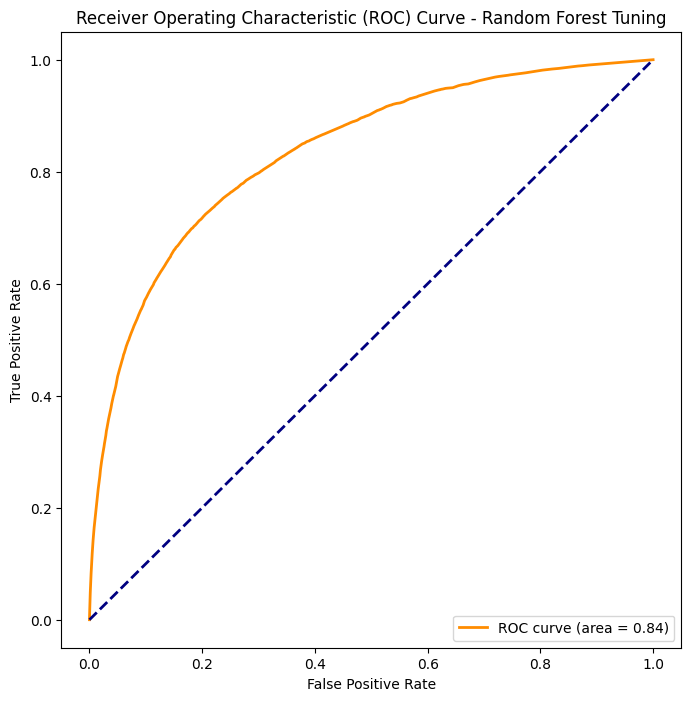

In [ ]:
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve, auc

# Assuming 'probability' is the column containing the predicted probabilities for class 1
y_pred_prob_tuning = np.array(predictions.select('probability').rdd.flatMap(lambda x: x[0]).collect())
y_true_tuning = np.array(predictions.select('patient_type').rdd.flatMap(lambda x: x).collect())

# Flatten the arrays in the 'probability' column
flatten_udf_tuning = F.udf(lambda arr: float(arr[1]), DoubleType())
predictions_tuning = predictions.withColumn('probability_flat', flatten_udf_tuning('probability'))

# Extract flattened probabilities and true labels
y_pred_prob_tuning = np.array(predictions_tuning.select('probability_flat').rdd.flatMap(lambda x: x).collect())
y_true_tuning = np.array(predictions_tuning.select('patient_type').rdd.flatMap(lambda x: x).collect())

# Compute ROC curve
fpr_tuning, tpr_tuning, thresholds_tuning = roc_curve(y_true_tuning, y_pred_prob_tuning)
roc_auc_tuning = auc(fpr_tuning, tpr_tuning)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_tuning, tpr_tuning, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc_tuning))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest Tuning')
plt.legend(loc='lower right')
plt.show()


<h3><b>TUNING MODEL MULTILAYER PERCEPTRON CLASSIFIER</b></h3>

<h4><b>SPLIT DATASET</b></h4>

In [ ]:
train_data,test_data = df_prediction.randomSplit([0.7,0.3])

<h4><b>CREATE MLP MODEL TUNING</b></h4>

In [ ]:
layers = [4, 10, 5, 2]
mlp = MultilayerPerceptronClassifier(layers=layers, labelCol='patient_type', featuresCol='independentFeature')

<h4><b>CREATE PARAMTER GRID FOR HYPERPARAMATER MODEL TUNING</b></h4>

In [ ]:
param_grid = (ParamGridBuilder()
    .addGrid(mlp.maxIter, [50, 100, 200])
    .addGrid(mlp.blockSize, [32, 64, 128])
    .addGrid(mlp.stepSize, [0.01, 0.1, 0.2])
    .build())

<h4><b>CREATE EVALUATOR MODEL</b></h4>

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='patient_type', predictionCol='prediction', metricName='accuracy')

<h4><b>CREATE CROSS VALIDATION MODEL</b></h4>

In [ ]:
cv = CrossValidator(estimator=mlp, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

<h4><b>TRAINING MODEL MLP TUNING</b></h4>

In [ ]:
mlp_tuning_model = cv.fit(train_data)

<h4><b>PREDICTION DATA FROM MODEL</b></h4>

In [ ]:
predictions = mlp_tuning_model.transform(test_data)

<h4><b>EVALUASI MODEL DENGAN ACCURACY</b></h4>

In [ ]:
evaluator_mlp = MulticlassClassificationEvaluator(
    labelCol='patient_type',
    predictionCol='prediction',
    metricName='accuracy'
)
accuracy_mlp = evaluator_mlp.evaluate(predictions)
print(f"Nilai Accuracy Model Dengan MLP Tuning : {accuracy_mlp:.2%}")

<h4><b>EVALUASI MODEL DENGAN F1-Score</b></h4>

In [ ]:
evaluator_mlp = MulticlassClassificationEvaluator(
    labelCol='patient_type',
    predictionCol='prediction',
    metricName='f1'
)
f1_mlp = evaluator_mlp.evaluate(predictions)
print(f"Nilai F1-Score Model Dengan MLP Tuning : {f1_mlp:.2%}")

<h4><b>EVALUASI MODEL DENGAN PRESISI</b></h4>

In [ ]:
evaluator_mlp = MulticlassClassificationEvaluator(
    labelCol='patient_type',
    predictionCol='prediction',
    metricName='weightedPrecision'
)
presisi_mlp = evaluator_mlp.evaluate(predictions)
print(f"Nilai Presisi Model Dengan MLP Tuning : {presisi_mlp:.2%}")

<h4><b>EVALUASI MODEL DENGAN RECALL</b></h4>

In [ ]:
evaluator_mlp = MulticlassClassificationEvaluator(
    labelCol='patient_type',
    predictionCol='prediction',
    metricName='weightedRecall'
)
recall_mlp = evaluator_mlp.evaluate(predictions)
print(f"Nilai Recall Model Dengan MLP Tuning : {recall_mlp:.2%}")

<h2><b>VISUALISASION BEST MODEL (RANDOM FOREST)</b></h2>

<h3><b>CONFUSSION MATRIX</b></h3>

<h4><b>MEMBUAT DATA PREDIKSI DARI MODEL RANDOM FOREST TUNING</b></h4>

In [ ]:
predictions = tuning_ranrest_model.transform(test_data)

<h4><b>MENDAPATKAN NILAI AKTUAL DAN PREDIKSI</b></h4>

In [ ]:
y_true = predictions.select('patient_type').toPandas()
y_pred = predictions.select('prediction').toPandas()

<h4><b>MEMBUAT CONFUSSION MATRIX</b></h4>

In [ ]:
conf_matrix = confusion_matrix(y_true, y_pred)

<h4><b>MEMBUAT DATAFRAME UNTUK VISUALISASI</b></h4>

In [ ]:
conf_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

<h4><b>VISUALISASI CONFUSSION MATRIX</b></h4>

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<h3><b>ACCURACY</b></h3>

<h4><b>MEMBUAT EVALUATOR</b></h4>

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="patient_type", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

<h4><b>MEMBUAT DATA UNTUK PLOTTING</b></h4>

In [ ]:
labels = ['Akurasi']
values = [accuracy]

<h4><b>VISUALISASI ACCURACY</b></h4>

In [ ]:
plt.bar(labels, values, color=['red'])

plt.xlabel('Metrik')
plt.ylabel('Nilai')
plt.title('Grafik Akurasi Model')

plt.show()